In [1]:
# Imports for project

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

<b> Group Members </b>

Miguel Garcia 

Alan Su 

Madeleine Appelmans 

Simran Gill 

Kevin Yu 


# Background and Information

Every week a new movie is realeased into theaters throughout the world. Movies have grown to become a giant industry as well as an entertainment phenomenon. At the end of each movie season there are also a series of awards shows the honor the successes of various films released throughout the year. Our goal in this analysis is to see if there are any observable characteristics of movies that allow us to predict their financial and critical success. We define financial success as the amount of revenue a movie earns and its critical success as its ratings. After this is done, we will also see if we can somehow analyze these characteristics to determine if we can predict the awards given out at the Oscars. This will be done using a Random Forst machine learning algorithm.

We predict that there will be certain characteristics that strongly correlate with the amount of revenue that a movie will earn. However, we also predict that this will not be the case with the movie's ratings, because it most likely takes more than these observable characteristics to determine its rating. With the same reasoning, we also believe it will be difficult to create a machine learning model that predicts the oscars.

# Data Preprocessing and Cleaning

In this analysis, we used two data sets, "The Movies Dataset," and the "IMDB database." 

Dataset Name: The Movies Dataset

Link to the dataset: https://www.kaggle.com/rounakbanik/the-movies-dataset
Number of observations: 45,000 This dataset contains a lot of metadata, including genre, budget, revenue, and much more. We will not be using all of the provided information (e.g. link to poster), as they are not relavent to our analysis. We also found out (as mentioned later throughout the analysis), that there were lots of missing pieces of data. For example, many of the movies did not contain budget and revenue information. Since there were so many of these, we had to remove them from our analysis as they would skew some of our data.

Dataset Name: The IMDB database

Link to the dataset: https://datasets.imdbws.com/
Number of observations: 20,000,000+ IMDB keeps up to date datasets that include basic information, crew information, episode information, principal cast information, ratings information, and individual-specific information. The interfaces of each dataset is clearly documented here: http://www.imdb.com/interfaces/ There are movies from 1874-2025 and information about people all across the movie industry.

Dataset Name: The Academy Awards dataset

Link to the dataset: https://www.kaggle.com/theacademy/academy-awards
This dataset contains all the winners of academies awards up to and including 2015

# How to get access to the data files

We've compiled all the data to a google drive under the link:<br>
https://drive.google.com/drive/folders/1Z9bpVQXuOASe5yyrzX0TOnXfwUMEa46N?usp=sharing<br>

1) Download the data files <br>
2) Place in a directory named 'cogs108_data' <br>
3) Keep 'cogs108_data' in the same directory as this file

# Privacy/Ethics Considerations

In terms of Ethics and Privacy, we didn’t come across any issues. A lot of the data has already been collected and contains little to no information on any individuals, as they are all based around movies. All of the data we collected and scraped was already publicly available from various sources. As for ethical concerns, we don’t believe that any conclusions we draw from analysing movie data would cause any kind of serious lasting harm. 


# Part 1 - Analysis of Financial and Critical Success

Our goal is to see if we can find any characteristics of a movie that can help predict its financial and critical success. For our case, we will define financial success as the revenue earned and critical success as the weighted ratings from IMDB. First we need to gather the data sets that we will be using and creating the data frame. We'll begin by creating a dataframe with the weighted ratings from movies since IMDB only provides the formula used and not the dataset itself.

In [2]:
# Renamed data from title.ratings.tsv.gz->data.tsv
ratings = pd.read_csv('cogs108_data/ratings.tsv',delimiter='\t')
# Renamed data from title.basics.tsv.gz->data.tsv
basics = pd.read_csv('cogs108_data/basics.tsv', delimiter='\t')

C:\Users\Miguel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Remove all things that arent movies
basics = basics[basics['titleType'] == "movie"]
# Remove all adult titles
basics = basics[basics['isAdult'] == 0]
# Remove unnecessary columns
basics = basics.drop(['titleType','originalTitle','isAdult','startYear','endYear','runtimeMinutes','genres'],axis=1)

In [4]:
# Do a inner join on movies that have both ratings and basic info
ratings_df = pd.merge(basics, ratings, on='tconst', how='inner')

In [5]:
# Add a new column with weighted ratings based on minimum votes
minVote = 30000

# Scroll down to the bottom of the following link to check how the weighted rating was calculated
# https://help.imdb.com/article/imdb/track-movies-tv/faq-for-imdb-ratings/G67Y87TFYYP6TWAV?ref_=helpsect_pro_2_4#
ratings_df = ratings_df.assign(weighted_ratings=((ratings_df['numVotes']/(ratings_df['numVotes']+minVote))*ratings_df['averageRating'])+(minVote/(ratings_df['numVotes']+minVote))*ratings_df['averageRating'].mean())
# Standardize movie names
ratings_df['primaryTitle']=ratings_df['primaryTitle'].str.strip()
ratings_df['primaryTitle']=ratings_df['primaryTitle'].str.lower()


ratings_df.rename(index=str, columns={"tconst": "imdb_id"}, inplace=True)


# Remove the comment below to see the weighted ratings DF
# df.sort_values(by=['weighted_ratings'], ascending=False)

Now let's get the other quantitative measures for movies, such as budget and revenue. We can then combine both dataframes on the IMDB ID to start our analysis.

In [6]:
budget_df = pd.read_csv("cogs108_data/movies_metadata.csv")

# Cleaning up the dataset for some useful analysis on budget since it contains A LOT of information
budget_df.drop(["adult", "belongs_to_collection", "genres", "homepage", "id", "original_language", "runtime", 
                "spoken_languages", "status", "tagline", "poster_path", "production_countries", 
                "original_title", "overview", "video"], inplace = True, axis=1)


# Strip whitespace and tolower for consistency
budget_df["title"]=budget_df["title"].str.strip()
budget_df["title"]=budget_df["title"].str.lower()

C:\Users\Miguel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# This function will be used to change some of the columns since some of them are numbers but as strings
def convertToInt(string):
    return int(string)

In [8]:
# Now we need to start cleaning our data because there are some incorrect inputs and 
# a lot of rows with missing budget and revenue information
print("Shape before cleaning - " + str(budget_df.shape))
budget_df = budget_df[(budget_df["budget"] != "0")]
budget_df = budget_df[(budget_df["revenue"] != 0)]

# For some reason the following rows were completely messed up so we have to remove them
budget_df = budget_df[(budget_df["budget"] != "/ff9qCepilowshEtG2GYWwzt2bs4.jpg")]
budget_df = budget_df[(budget_df["budget"] != "/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg")]
budget_df = budget_df[(budget_df["budget"] != "/zaSf5OG7V8X8gqFvly88zDdRm46.jpg")]

print("Shape after cleaning - " + str(budget_df.shape))

Shape before cleaning - (45466, 9)
Shape after cleaning - (5381, 9)


In [9]:
# Now let's go ahead and apply the function we made earlier and now combine our dataframes
budget_df["budget"] = budget_df["budget"].apply(convertToInt)
combined_df = pd.merge(ratings_df, budget_df, on="imdb_id")

combined_df.drop(["primaryTitle", "popularity", "production_companies"], axis=1, inplace=True)


# Uncomment the following line to see the new DF
# combined_df


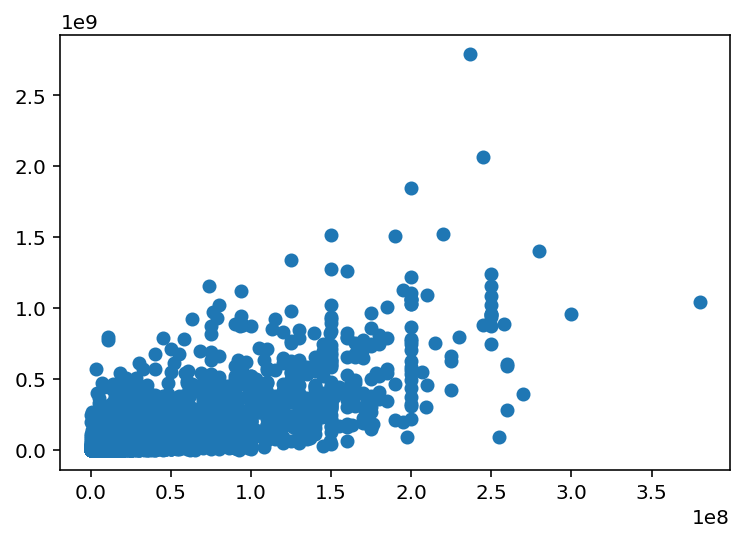

In [10]:
plt.scatter(combined_df.budget, combined_df.revenue)

It's somewhat hard to see any sort of relationship with this graph because of the numbers. To try to see anything interesting we'll go ahead and apply a log transformation to both the budget and revenue.

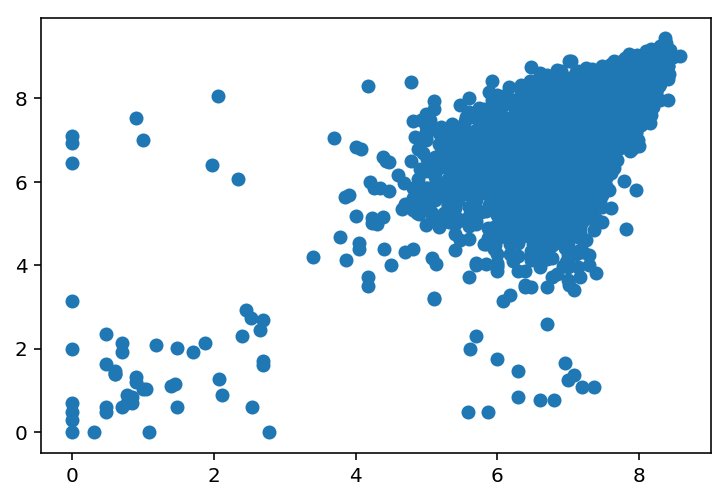

In [11]:
combined_df["budget"] = np.log10(combined_df["budget"])
combined_df["revenue"] = np.log10(combined_df["revenue"])

#Scatter after log transform
plt.scatter(combined_df.budget, combined_df.revenue)

Now we can definitely see that there is some sort of correlation between the budget that a movie receives and the revenue that it earns. We can see that there is this general positive trend where a movie that has a higher budget earns more revenue. This makes sense since a higher budget usually means higher faith in the outcome by the company funding the movie.

We do notice that this is not a perfect correlation, however. Just because a movie receives a high budget does not mean that is guaranteed to do well. The opposite of this is also true. 

In [12]:
# We have to create the following function if we want to do any more useful analysis with the budget and revenue
def revertLog(input):
    return np.float_power(10, input)


combined_df["budget"] = combined_df["budget"].apply(revertLog)
combined_df["revenue"] = combined_df["revenue"].apply(revertLog)

Now that we've seen that there is a correlation between a movie's budget and its revenue, we want to ask if there are any other factors that indicate a movie will do well financially. Another characteristic that we may want to consider is the time of the year that a movie does well. It may be possible that movies that are released in a certain part of the year are more likely to generate more revenue than others.

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


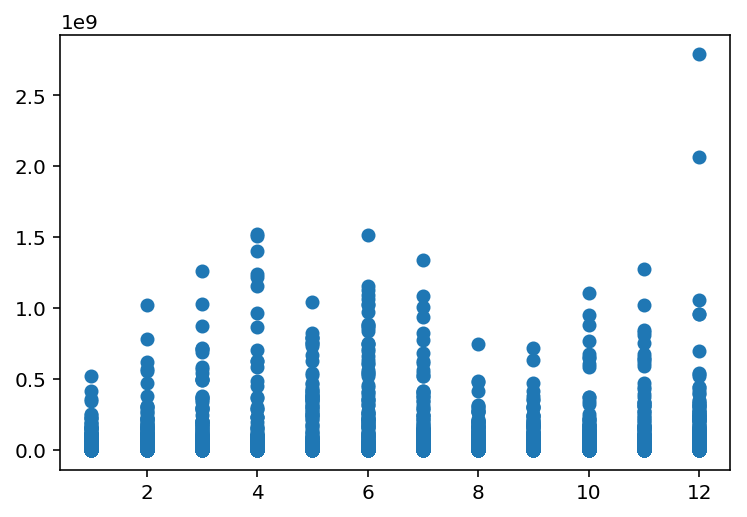

In [13]:
# Strip whitespace and tolower for consistency
combined_df["title"]=combined_df["title"].str.strip()
combined_df["title"]=combined_df["title"].str.lower()


# We have to create ths new column age so we can specify which movies we want to use. Since this dataset
# includes a large number of movies and since the trend in watching movies has changed, we only want 
# to consider a subset for certain analysis.
combined_df["age"] = 0
    
for index, row in combined_df.iterrows():
    year = int(row["release_date"][0:4])
    combined_df.set_value(index,'age', (2017 - year))

# Here we will only be considering movies released in the past 10 years
smaller_combined_df = combined_df[combined_df["age"] < 10]

# We section of the timeline by month
for index, row in smaller_combined_df.iterrows():
    month = int(row["release_date"][5:7])
    smaller_combined_df.set_value(index, "release_date", month)
    
    
plt.scatter(smaller_combined_df.release_date, smaller_combined_df.revenue)

We can see that there's some sort of relationship between month of release and revenue....maybe? It seems like there is some sort of fluctuations, but it's hard to tell exactly what that is. To help us see this trend, we can average out the revenue per month over these movies and display those.

<BarContainer object of 12 artists>

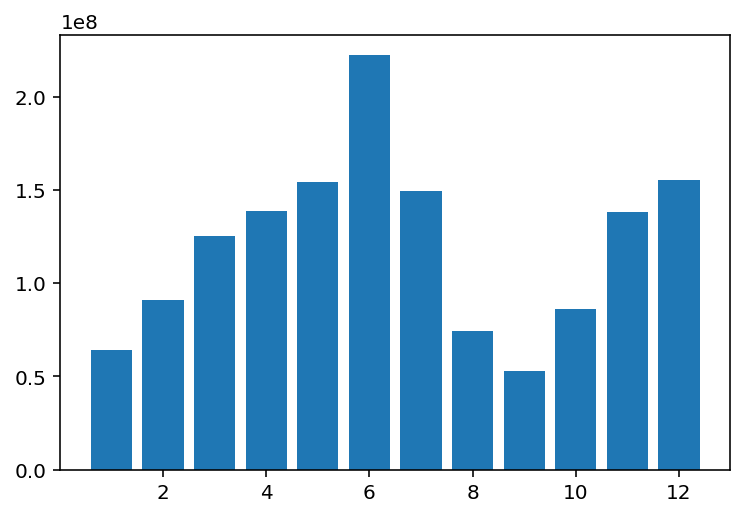

In [14]:
temp_frame = None
months = list()
averages = list()

# Loop that gets the averages for each month
for i in range (1,13):
    temp_frame = smaller_combined_df[smaller_combined_df["release_date"] == i]
    averages.append(temp_frame["revenue"].mean())
    months.append(i)


plt.bar(months, averages)

Now that we took the averages, we can definitely see a trend. It looks like movies that are released in the 
April - July area are likely to earn more revenue than other months. This does seem consistent with the fact that
many more people (like students) have more time during these summer months. As a result, these people are likely 
to see more movies during this period. To confirm this, however, we would probably need to do a bigger analysis 
with more data.

Up until this point we have considered only revenue as a measure of success for a movie. Although this is 
important to the movie industry, there is also another important factor to consider: ratings. Movies that are
rated much more highly are usually praised by many people. As a result, we can use ratings to measure the 
critical success of a movie. We can begin by using the same variables that we did for revenue: budget 
and month of release.

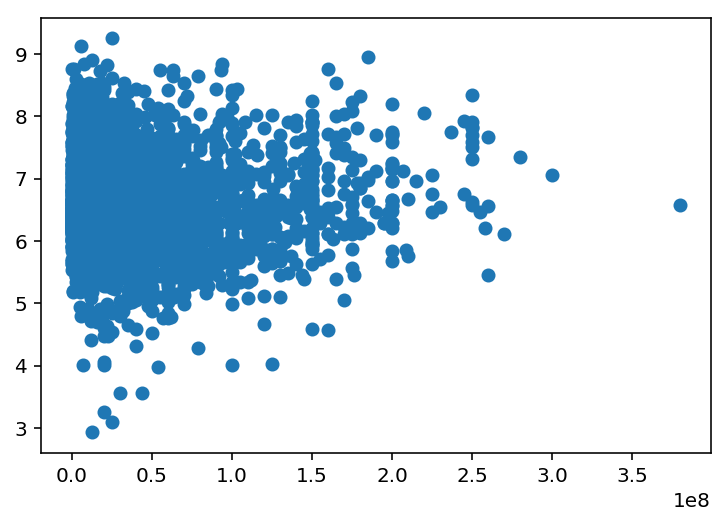

In [15]:
plt.scatter(combined_df.budget, combined_df.weighted_ratings)

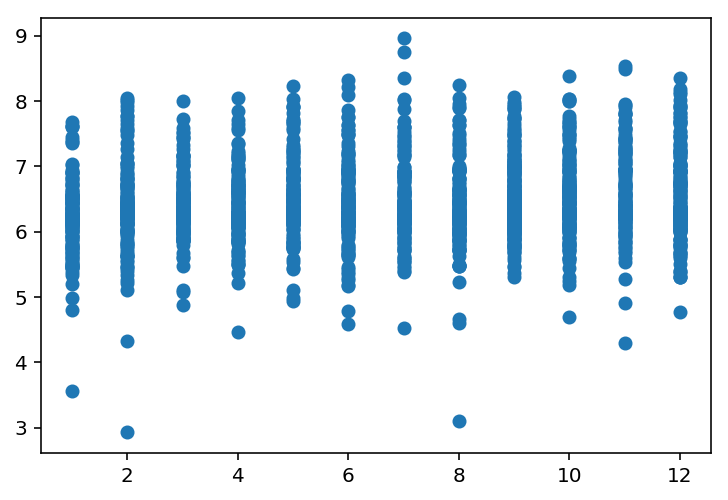

In [16]:
plt.scatter(smaller_combined_df.release_date, smaller_combined_df.weighted_ratings)

<BarContainer object of 12 artists>

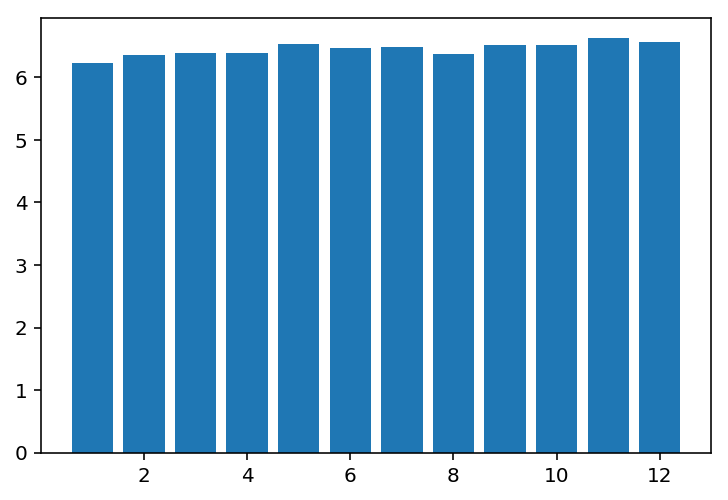

In [17]:
temp_frame = None
months = list()
averages = list()
for i in range (1,13):
    temp_frame = smaller_combined_df[smaller_combined_df["release_date"] == i]
    averages.append(temp_frame["weighted_ratings"].mean())
    months.append(i)


plt.bar(months, averages)

So, unlike revenue and the release month, it seems like there is no relationship between the ratings of a movie and its release month. That is, there is no bias for a movie to get a higher rating released at one particular month when compared to another. This makes sense with the fact that the rating a movie gets is based on its qualities and is difficult to influence by outside factors.

## Director Analysis

Now we are going to take a slight detours with our analysis. As we were going through the analysis with budgets, revenues, and ratings, we noticed some interesting traits among the directors. In this small subsection of the notebook, we take a look at how the director of a movie relates to the budget of a movie as well as the revenue. We also explore the differences between male and female directors in this regard.

In [18]:
# Read in the dataset to a pandas dataframe
metadata = pd.read_csv('cogs108_data/movies_metadata.csv')
credits = pd.read_csv('cogs108_data/credits.csv')

C:\Users\Miguel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
# Remove cast column in credits
credits = credits.drop('cast', axis=1)

In [20]:
# This function takes a string element from the crew column and returns the
# name of the director
def getDirector(row):
    start = row.find("\'Director\'")
    nameBegin = row[start:len(row)].find("\'name\': \'")
    number = len("\'name\': \'")
    nameEnd = row[start+nameBegin + number:len(row)].find("\'")
    name = row[start+nameBegin + number:start+nameBegin + number + nameEnd]
    if len(name) == 0:
        return '0'
    return name
    

In [21]:
# Function parses the gender of the director
def getDirectorGender(row):
    end = row.find('Director')
    start = row[0:end].rfind('\'gender\': ')
    gender = row[start + len('\'gender\': '): start + len('\'gender\': ') + 1]
    if len(gender) == 0:
        return -1
    return gender
    

In [22]:
# Creating new columns from the parsed data
credits['director'] = credits['crew'].apply(getDirector)
credits['gender'] = credits['crew'].apply(getDirectorGender)

In [23]:
# Removing rows that have missing or unknown gender
credits = credits[credits['gender'] != -1]
credits = credits[credits['gender'] != '0']
# Removing rows that have missing director
credits = credits[credits['director'] != 'it_id']

In [24]:
# Dropping the now unnecessary crew column
credits = credits.drop('crew', axis=1)

In [25]:
# Numbers of each gender in the dataset
numFdirectors = sum(credits['gender'] == '1')
numMdirectors = sum(credits['gender'] == '2')

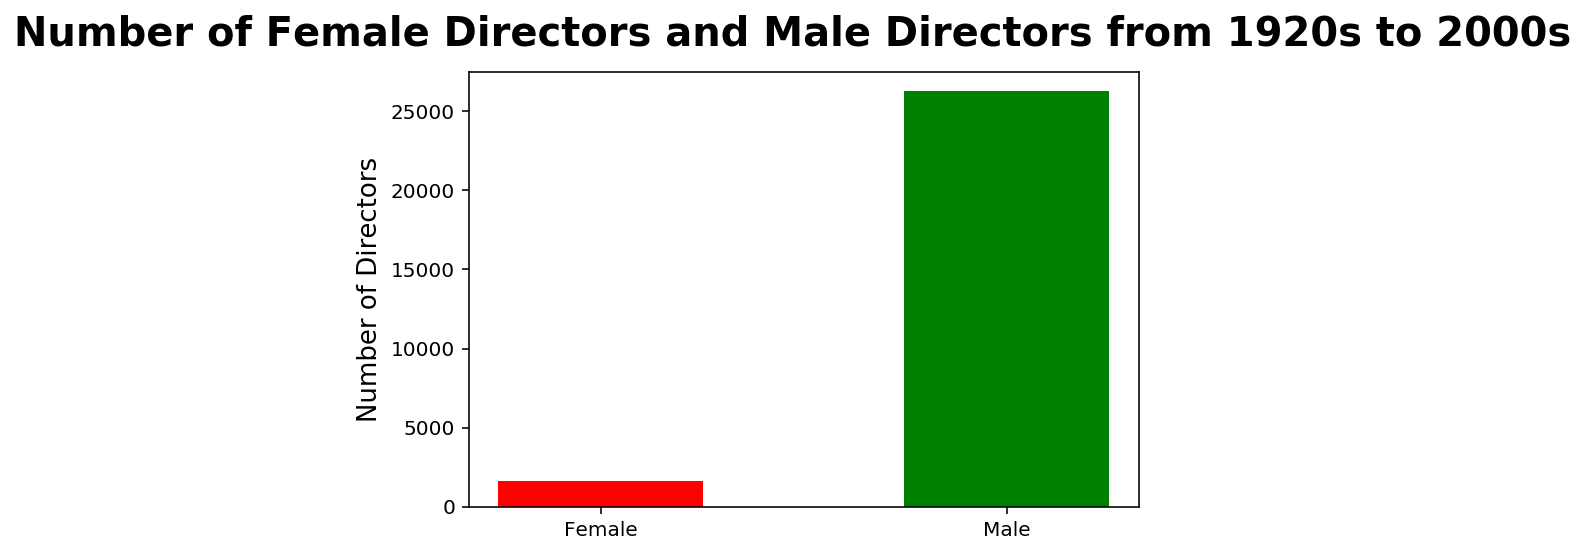

In [26]:
y = [numFdirectors, numMdirectors]
N = len(y)
x = range(N)
width = 0.5
barlist = plt.bar(x, y, width)
plt.suptitle('Number of Female Directors and Male Directors from 1920s to 2000s', fontsize=20, fontweight='bold')
plt.ylabel('Number of Directors', fontsize=13)
barlist[0].set_color('r')
barlist[1].set_color('g')
plt.xticks(x, ['Female', 'Male'])
plt.show()

This graph shows the ratio of female directors to male directors in the movie world. 

In [27]:
# Grabbing the ten directors who have made the most movies
director_frequency = credits['director'].value_counts()[0:10]

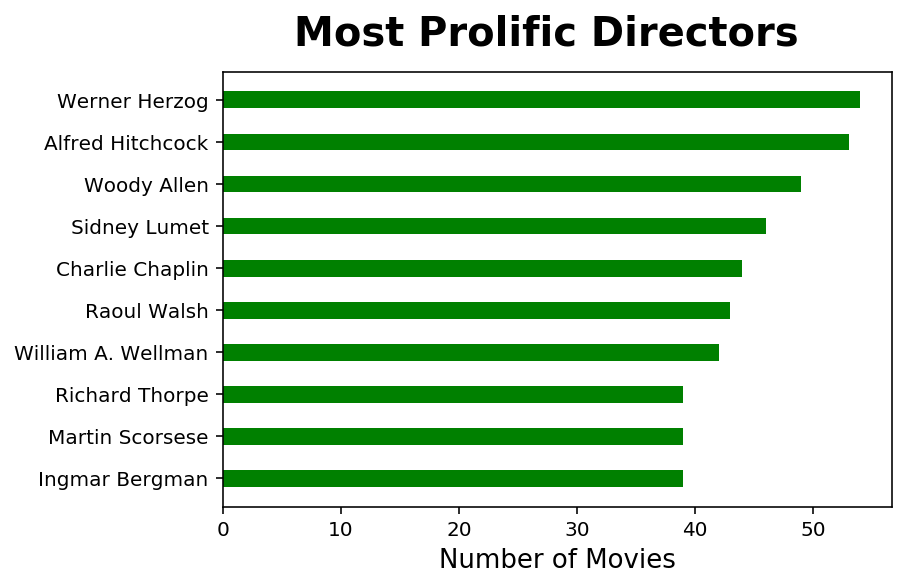

In [28]:
list_of_directors = director_frequency.index.tolist()[::-1]
y = director_frequency.tolist()[::-1]
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='g')
plt.suptitle('Most Prolific Directors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Movies', fontsize=13)
plt.yticks(x, list_of_directors)
plt.show()

This graph shows the ten directors who have made the highest number of films. If you notice however, there are no women on this list. The next graph shows the most prolific female directors for comparison.

In [29]:
# Grabbing the ten female directors who have made the most movies
female_directors = credits[credits['gender'] == '1']
directorF_frequency = female_directors['director'].value_counts()[0:10]

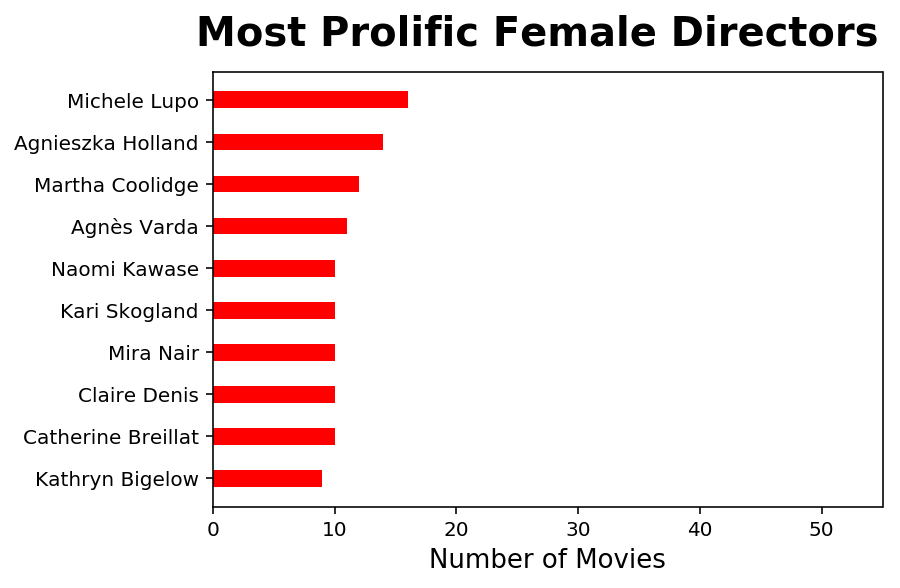

In [30]:
list_of_directorsF = directorF_frequency.index.tolist()[::-1]
y = directorF_frequency.tolist()[::-1]
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='r')
plt.suptitle('Most Prolific Female Directors', fontsize=20, fontweight='bold')
plt.xlim([0, 55])
plt.xlabel('Number of Movies', fontsize=13)
plt.yticks(x, list_of_directorsF)
plt.show()

This graph shows the most prolific female directors. Amusingly(or not), the woman with the highest number of films is Michele Lupo. Lupo is actually a man; he was coded wrong in the dataset because his name is usually considered a woman's name in the U.S. You might notice that many of the names on this list do not look western. There are only two Americans on this list, Mira Nair and Martha Coolidge. This suggests that other countries have done a better job of supporting women in leadership roles in the moviemaking industry. In particular, half of these women are French.  I would like to do further research on why France has so many female filmmakers but that is for another project. I did find an article on this subject which can be seen here: https://www.theguardian.com/film/2011/mar/24/france-women-directors

## Budget Analysis

This upcoming analysis pulls in budget and revenue information. This information is not available for every movie in our dataset so we were only able to analyze ten percent of our original data. This means that the ten most prolific directors change from the previous analysis. It also skews our data toward western directors as the dataset is more likely to have budget information on western films.

In [31]:
# Keeping only the relevent columns in movie_metadata dataset
new_metadata = metadata[['budget', 'revenue', 'id']]

In [32]:
# Clean movies_metadata Dataframe
new_metadata['id'] = new_metadata['id'].apply(pd.to_numeric, errors='coerce')
new_metadata = new_metadata[np.isfinite(new_metadata['id'])]

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
# Merge two datasets
direct_df = new_metadata.merge(credits, on='id')

In [34]:
# Turn budget column into numeric data
direct_df['budget'] = direct_df['budget'].apply(pd.to_numeric)

In [35]:
# Replace all 0 values with nan
direct_df['budget'].replace(0, np.nan, inplace=True)
direct_df['revenue'].replace(0, np.nan, inplace=True)

In [36]:
# Drop all nan values
direct_df = direct_df.dropna()

In [37]:
# Gets average budget for the 10 most prolific directors
mean_budget = list()

director_frequency = direct_df['director'].value_counts()[0:10]
director_frequency = director_frequency.index.tolist()

def get_mean_budget(director):
    return np.mean(direct_df[direct_df['director'] == director]['budget'])

for i in director_frequency:
    mean_budget.append(get_mean_budget(i))


In [38]:
# Sort mean budget
zipped = zip(director_frequency, mean_budget)
sorted_zipped = sorted(zipped, key=lambda x: x[1])
director_frequency, mean_budget = zip(*sorted_zipped)

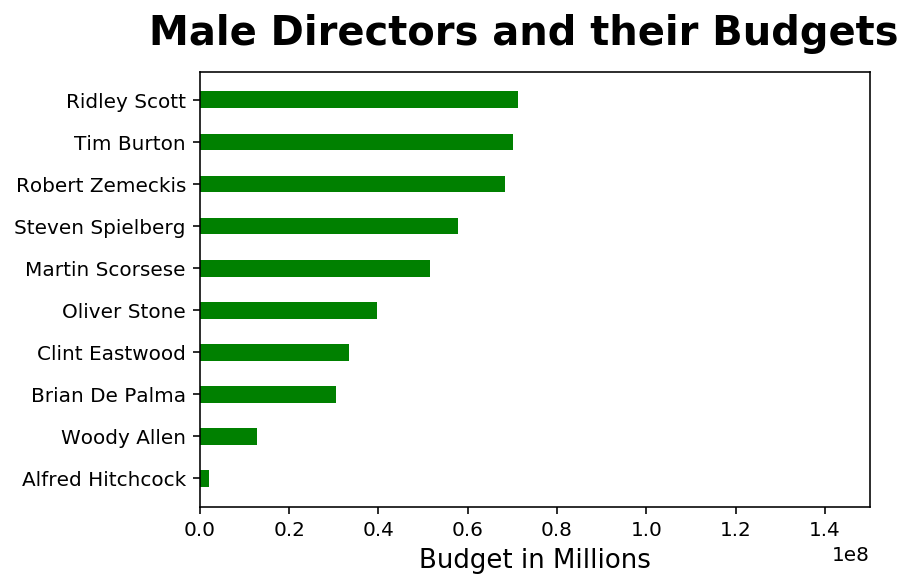

In [39]:
y = mean_budget
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='g')
plt.suptitle('Male Directors and their Budgets', fontsize=20, fontweight='bold')
plt.xlabel('Budget in Millions', fontsize=13)
plt.yticks(x, director_frequency)
plt.xlim([0, 1.5e8])
plt.show()

This graph shows the top 10 most prolific directors and the average budget they worked with on a movie. It is sorted by average budget. Again, all of these directors are men, so the next graph looks at female directors for comparison.

In [40]:
female_directors = direct_df[direct_df['gender'] == '1']
mean_budget_female = list()

directorF_frequency = female_directors['director'].value_counts()[0:10]
directorF_frequency = directorF_frequency.index.tolist()

for i in directorF_frequency:
    mean_budget_female.append(get_mean_budget(i))
    

In [41]:
# Sort mean_budget
zipped = zip(directorF_frequency, mean_budget_female)
sorted_zipped = sorted(zipped, key=lambda x: x[1])
directorF_frequency, mean_budget_female = zip(*sorted_zipped)

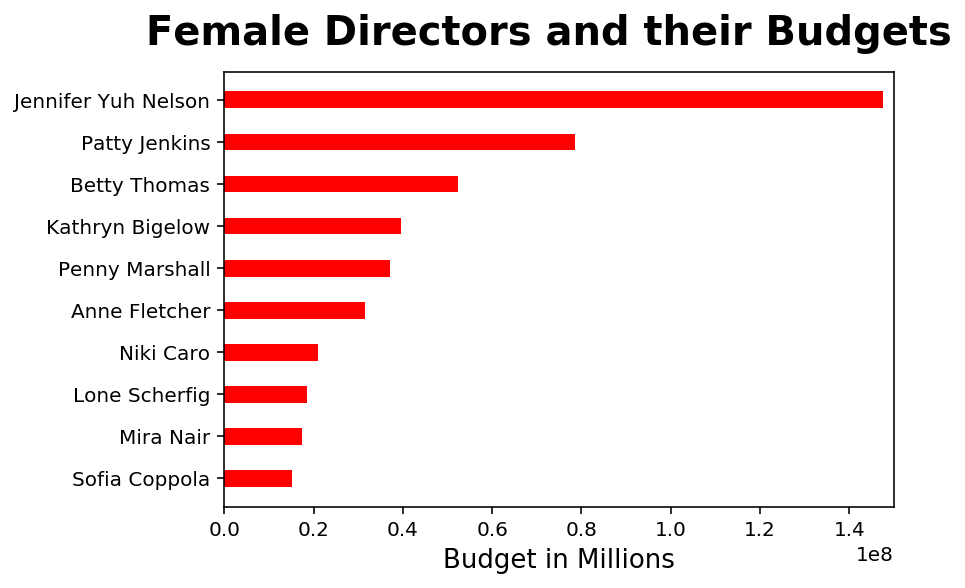

In [42]:
y = mean_budget_female
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='r')
plt.suptitle('Female Directors and their Budgets', fontsize=20, fontweight='bold')
plt.xlabel('Budget in Millions', fontsize=13)
plt.yticks(x, directorF_frequency)
plt.xlim([0, 1.5e8])
plt.show()

This graph shows the average budget that the ten most prolific female directors worked with. It is smaller than the male directors. Budget and revenue comparison are difficult with respect to gender; there is much more data on men than on women. For example, Jennifer Yuh Nelson has the highest average budget out of the directors. The reason why it looks like she has a huge average budget is that she directed Kung Fu Panda 2, a movie which made her the first women to solely direct an animated Hollywood movie. In the database she has only directed two movies which is another reason why her average budget is so high.

Information about Jennifer Yuh Nelson was snagged from https://en.wikipedia.org/wiki/Jennifer_Yuh_Nelson. 

## Revenue Analysis

The next analysis will be looking at how much money films make tied to the top ten most prolific directors. It will be analyzing net profit with respect to gender.

In [43]:
# Getting the mean revenue for female directors
gross_earnings_f = list()

def get_mean_revenue(director):
    return np.mean(direct_df[direct_df['director'] == director]['revenue'] - direct_df[direct_df['director'] == director]['budget'])

for i in directorF_frequency:
    gross_earnings_f.append(get_mean_revenue(i))

In [44]:
# Sort mean revenue
zipped = zip(directorF_frequency, gross_earnings_f)
sorted_zipped = sorted(zipped, key=lambda x: x[1])
directorF_frequency, gross_earnings_f = zip(*sorted_zipped)

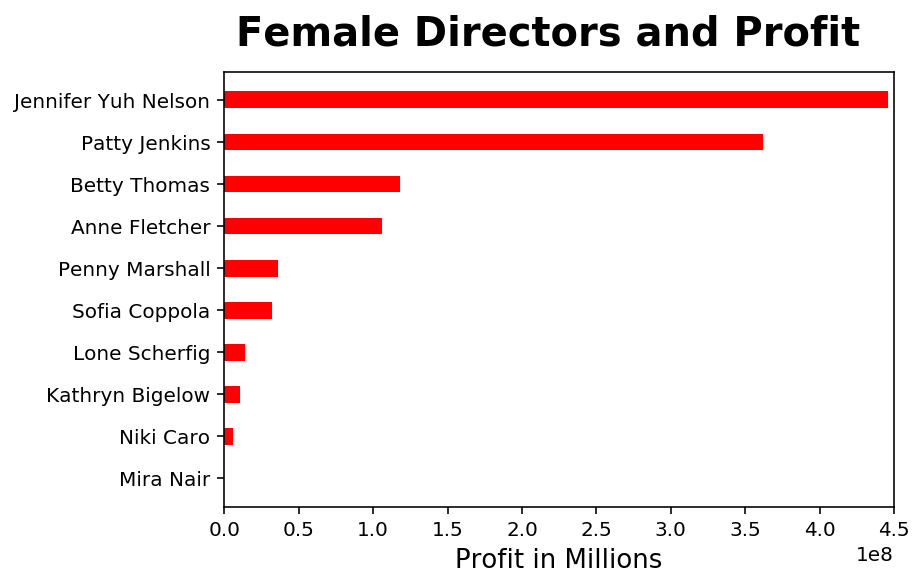

In [45]:
y = gross_earnings_f
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='r')
plt.suptitle('Female Directors and Profit', fontsize=20, fontweight='bold')
plt.xlabel('Profit in Millions', fontsize=13)
plt.yticks(x, directorF_frequency)
plt.xlim([0, 4.5e8])
plt.show()

This graph shows the average net profit for the ten most prolific female directors. Again, Jennifer Yuh Nelson is tied to the highest average profit. For comparison, the next graph will show the highest average profit for male directors.

In [46]:
# Net profit for male directors
gross_earnings_m = list()

for i in director_frequency:
    gross_earnings_m.append(get_mean_revenue(i))

In [47]:
# Sort mean revenue
zipped = zip(director_frequency, gross_earnings_m)
sorted_zipped = sorted(zipped, key=lambda x: x[1])
director_frequency, gross_earnings_m = zip(*sorted_zipped)

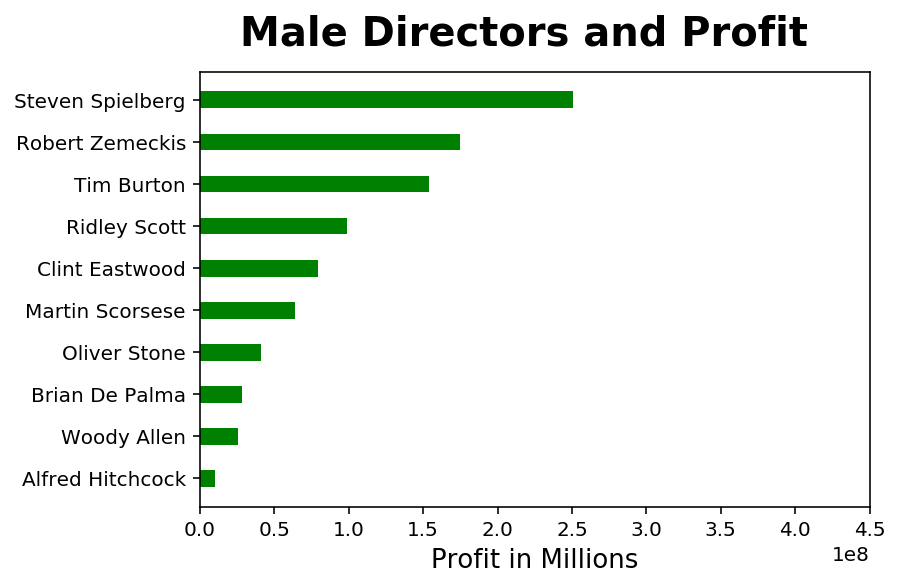

In [48]:
y = gross_earnings_m
N = len(y)
x = range(N)
width = 0.4
barlist = plt.barh(x, y, width, color='g')
plt.suptitle('Male Directors and Profit', fontsize=20, fontweight='bold')
plt.xlabel('Profit in Millions', fontsize=13)
plt.yticks(x, director_frequency)
plt.xlim([0, 4.5e8])
plt.show()

This graph shows the average profit made by the top ten most prolific male directors. It is challenging to compare this graph with the previous graph because there are so few female directors. However these two graphs look similar, with the male directors earning slightly more than the female directors. This could be due to the smaller budgets female directors work with. Most importantly, the difference between these two graphs is much smaller than the previous male/female director comparison graphs. This suggests that female directors make just as much money for film companies as men. 

# Part 2 - Machine Learning Attempt

In this next part of our analysis, we attempt to find out if it is possible to predict the Oscars movie awards based on pure data alone. To accomplish this, we use the Random Forest machine learning algorithm to process certain pieces of data that were available to us. This will allow us to see if there are certain observable characteristics of movies that make it easier to prediect whether it will get a certain award or not.

# Data Preprocessing and Cleaning for Part 2

Just like in part 1, we had to do some preprocessing and cleaning in order to set up our machine learning analysis. We had to remove the extra columns that did not contribute to the analysis and also remove the movies that had missing pieces of data. On top of this, we had to create three different dataframes that would be used in our machine learning analysis: a dataframe for production awards, a dataframe for best picture awards, and a dataframe for actor awards.

For production awards we dropped non numeric columns that are not being used as features such as ceremony, year and film. After, we made a y label column that indicates if a given movie got any type of production award. 1 for yes and 0 for no. We also calculated a weighted rating average.

For best picture awards we also dropped the same non numeric columns. We also calculated a weighted rating average.

For actor awards we dropped the same non numeric columns and created a y label that indicates whether the movie got an actor/actress award with label 1 for yes and 0 for no. We also calculated a weighted rating average.

Remaining features for each data frame predictor are: nominated prediction, month, budget, revenue, numvotes, weighted ratings and then it has its respective label for the predictor.

## Oscars Best Picture
We use the Oscars dataset to combine compile all the movies that either got nominated or was awarded Best Picture.

In [49]:
# Import database
df_BP = pd.read_csv('cogs108_data/awards.csv')

# Drop unnecessary columns
df_BP = df_BP[['Award','Winner','Name','Film']]

# Uncomment the following line to check all the award categories
# df_BP['Award'].unique()

In [50]:
# Replace all the variant names of Best Picture into Best Picture
bp_variants = {'Outstanding Picture', 'Outstanding Production', 'Outstanding Motion Picture', 'Best Motion Picture', 'Best Picture'}

for index, row in df_BP.iterrows():
    if(row['Award'] in bp_variants):
        df_BP.loc[index,'Award'] = 'Best Picture'

In [51]:
# Only keep best picture awards
df_BP = df_BP[df_BP['Award']=='Best Picture']

We noticed that there are 89 pictures instead of the expected 88. We went through them by hand and found that M*A*S*H was put under winning when it should not have. Also there are movies in which the producer is mistakenly put as film name.

In [52]:
# M*A*S*H was not a winner
df_BP.loc[4852,'Winner']=np.nan
# Change to correct film names
df_BP.loc[21,'Name']="Wings"
df_BP.loc[64,'Name']="The Broadway Melody"

Several of the nominations had wrong names too...

In [53]:
df_BP.loc[19,'Name']="The Racket"
df_BP.loc[20,'Name']="7th Heaven"
df_BP.loc[62,'Name']="Alibi"
df_BP.loc[63,'Name']="In Old Arizona"
df_BP.loc[65,'Name']="Hollywood Revue"
df_BP.loc[66,'Name']="The Patriot"

In [54]:
# Now we can drop the name row to only have film name
df_BP = df_BP[['Name','Winner']]

In [55]:
df_BP['Name'].unique().size

523

In [56]:
df_BP['Name'].value_counts()

Heaven Can Wait                                       2
Mutiny on the Bounty                                  2
Moulin Rouge                                          2
Cleopatra                                             2
Romeo and Juliet                                      2
Boys Town                                             1
Quo Vadis                                             1
Here Comes the Navy                                   1
The Curious Case of Benjamin Button                   1
Top Hat                                               1
Becket                                                1
Marty                                                 1
The Turning Point                                     1
Born on the Fourth of July                            1
The Informer                                          1
Whiplash                                              1
Shakespeare in Love                                   1
A Passage to India                              

Some movie title nominated/won for Best Picture in different years! But that's OK because it's just 5 entires out of 528!!

In [57]:
# Strip whitespace and lowercase the movie titles for consistency
df_BP['Name']=df_BP['Name'].str.strip()
df_BP['Name']=df_BP['Name'].str.lower()
df_BP['Winner'].fillna(0,inplace=True)

In [58]:
# Everything in this dataset is by default nominated
df_BP['Nominated']=1

In [59]:
# Uncomment the following line to see the Best Picture dataframe
# df_BP

## Month of Release
Using the movies dataset, we try to analyze when each movie was released.

In [60]:
dfm = pd.read_csv('cogs108_data/movies_metadata.csv')
dfm.dropna(subset=['release_date'], inplace = True)

C:\Users\Miguel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [61]:
def replace(date):
    output = date[5:7]
    return output

# Use apply() to extra only the month of release
dfm['release_date']=dfm['release_date'].apply(replace)
dfm=dfm[["title","imdb_id","release_date"]]

In [62]:
# Strip whitespace and tolower for consistency
dfm["title"]=dfm["title"].str.strip()
dfm["title"]=dfm["title"].str.lower()

In [63]:
# Remove all rows with blank release dates
dfm = dfm[dfm["release_date"]!=""]

In [64]:
# Set all month columns as 0 by default
dfm['Jan-Feb']=0.0
dfm['Mar-Apr']=0.0
dfm['May-Jun']=0.0
dfm['Jul-Aug']=0.0
dfm['Sept-Oct']=0.0
dfm['Nov-Dec']=0.0

# Set each month category with repective truth value
for index,row in dfm.iterrows():
    month_num = int(row['release_date'])
    if(month_num <=2):
        dfm.loc[index,'Jan-Feb']=1.0
    elif(month_num<=4):
        dfm.loc[index,'Mar-Apr']=1.0
    elif(month_num<=6):
        dfm.loc[index,'May-Jun']=1.0
    elif(month_num<=8):
        dfm.loc[index,'Jul-Aug']=1.0
    elif(month_num<=10):
        dfm.loc[index,'Sept-Oct']=1.0
    elif(month_num<=12):
        dfm.loc[index,'Nov-Dec']=1.0

In [65]:
# Uncomment the following to see the month dataframe
# dfm

## IMDB Weighted Ratings
Using the IMDB dataset, we want to create a dataframe that notes the IMDB ratings of each movie

In [66]:
# Renamed data from title.ratings.tsv.gz->data.tsv to ratings.tsv
ratings = pd.read_csv('cogs108_data/ratings.tsv',delimiter='\t')
# Renamed data from title.basics.tsv.gz->data.tsv to basics.tsv
basics = pd.read_csv('cogs108_data/basics.tsv', delimiter='\t')

C:\Users\Miguel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
# Remove all things that arent movies
basics = basics[basics['titleType'] == "movie"]
# Remove all adult titles
basics = basics[basics['isAdult'] == 0]
# Remove unnecessary columns
basics = basics.drop(['titleType','originalTitle','isAdult','startYear','endYear','runtimeMinutes','genres'],axis=1)

In [68]:
# Do a inner join on movies that have both ratings and basic info
df = pd.merge(basics, ratings, on='tconst', how='inner')
# Dont drop the IMDB id just in case for matching
#df = df.drop(['tconst'], axis=1)

Since a movie could get a 10/10 rating with very few votes, it's only fair for movies to be weighted based on the number of votes.

In [69]:
# Add a new column with weighted ratings based on minimum votes
minVote = 30000

# Scroll down to the bottom of the following link to check how the weighted rating was calculated
# https://help.imdb.com/article/imdb/track-movies-tv/faq-for-imdb-ratings/G67Y87TFYYP6TWAV?ref_=helpsect_pro_2_4#
df = df.assign(weighted_ratings=((df['numVotes']/(df['numVotes']+minVote))*df['averageRating'])+(minVote/(df['numVotes']+minVote))*df['averageRating'].mean())
# Standardize movie names
df['primaryTitle']=df['primaryTitle'].str.strip()
df['primaryTitle']=df['primaryTitle'].str.lower()


df.sort_values(by=['weighted_ratings'], ascending=False)

,tconst,primaryTitle,averageRating,numVotes,weighted_ratings
57541,tt0111161,the shawshank redemption,9.3,1928712,9.253596
33745,tt0068646,the godfather,9.2,1319020,9.134848
121542,tt0468569,the dark knight,9.0,1899597,8.957560
35590,tt0071562,the godfather: part ii,9.0,911219,8.912994
57397,tt0110912,pulp fiction,8.9,1506704,8.848662
72331,tt0167260,the lord of the rings: the return of the king,8.9,1376743,8.843919
56012,tt0108052,schindler's list,8.9,993617,8.822929
204075,tt5813916,the mountain ii,9.6,94942,8.800498
28288,tt0060196,"the good, the bad and the ugly",8.9,571561,8.768856
21197,tt0050083,12 angry men,8.9,533701,8.760048


## Production Awards
We want to see which movies were nominated production awards and which movies won which awards.

In [70]:
awards_df = pd.read_csv("cogs108_data/awards.csv")

# For some reason the dataset switched the name/film columns starting at the 3rd ceremony
# We had to compensate for this by moving the name of the film to the correct column for the first 3 ceremonies
for index, row in awards_df.iterrows():
    if(row["Ceremony"] < 3):
        awards_df.set_value(index,'Name',row["Film"])


# Drop the Ceremony and Year category since they aren't important
awards_df.drop(["Ceremony", "Year", "Film"], axis=1, inplace=True)
awards_df.rename(columns={'Name': 'Film'}, inplace=True)
# Strip whitespace and tolower for consistency
awards_df["Film"]=awards_df["Film"].str.strip()
awards_df["Film"]=awards_df["Film"].str.lower()

awards_df = awards_df.fillna(0)


# These are all the awards we consider as production awards
awards = ["Film Editing", "Cinematography", "Makeup", "Production Design", "Art Direction",
         "Sound Editing", "Sound Mixing", "Special Effects", "Special Visual Effects", 
          "Special Achievement Award (Visual Effects)", "Visual Effects", "Engineering Effects"]


# Remove all of the rows that do not pertain to any of the production related awards
awards_df = awards_df[awards_df["Award"].isin(awards)]

# Number of nominations for production related awards 
nominations = awards_df["Film"].value_counts()

# Remove the nominations and only get the winenrs
# awards_df = awards_df[awards_df["Winner"] == 1]

# Numer of winners for production related awards
winners_count = awards_df["Film"].value_counts()



C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


In [71]:
# Production Design = Art Design
# Special Effects = Special Visual Effects = Visual Effects = Engineering Effects = Special Achievement Award (Visual Effects)
# Make a new DF indexed by film name
prod_awards=pd.DataFrame(columns=['Film','Nominated Production',"Film Editing", "Cinematography", "Makeup", "Production Design",
         "Sound Editing", "Sound Mixing", "Visual Effects"])

In [72]:
prod_awards['Film'] = awards_df['Film'].unique()
# Initialize all fields to 0
prod_awards=prod_awards.fillna(0)
prod_awards

,Film,Nominated Production,Film Editing,Cinematography,Makeup,Production Design,Sound Editing,Sound Mixing,Visual Effects
0,sunrise,0,0,0,0,0,0,0,0
1,the dove; tempest,0,0,0,0,0,0,0,0
2,7th heaven,0,0,0,0,0,0,0,0
3,the devil dancer; the magic flame; sadie thompson,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,wings,0,0,0,0,0,0,0,0
6,the patriot,0,0,0,0,0,0,0,0
7,the bridge of san luis rey,0,0,0,0,0,0,0,0
8,dynamite,0,0,0,0,0,0,0,0
9,alibi; and the awakening,0,0,0,0,0,0,0,0


In index 1, for example, you can see that there is actually two movies listed in one cell. We need to deal with any instance of this. Fortunately, it only occurs a few times, so we can do everything manually.

In [73]:
# Removing specific movie names that put more than one movie in the same name
prod_awards = prod_awards[prod_awards['Film']!="the devil dancer; the magic flame; sadie thompson"]
prod_awards = prod_awards[prod_awards['Film']!="the dove; tempest"]
prod_awards = prod_awards[prod_awards['Film']!="alibi; and the awakening"]
prod_awards = prod_awards[prod_awards['Film']!="four devils; and street angel"]
# Removing specific movie names that put more than one movie in the same name
awards_df = awards_df[awards_df['Film']!="the devil dancer; the magic flame; sadie thompson"]
awards_df = awards_df[awards_df['Film']!="the dove; tempest"]
awards_df = awards_df[awards_df['Film']!="alibi; and the awakening"]
awards_df = awards_df[awards_df['Film']!="four devils; and street angel"]

In [74]:
# Manually insert all the names with multiple production awards
prod_awards.loc[884,"Film"]="the dove"
prod_awards.loc[885,"Film"]="tempest"
prod_awards.loc[886,"Film"]="the devil dancer"
prod_awards.loc[887,"Film"]="the magic flame"
prod_awards.loc[888,"Film"]="saddie thompson"
prod_awards.loc[889,"Film"]="alibi"
prod_awards.loc[890,"Film"]="the awakening"
prod_awards.loc[891,"Film"]="four devils"
prod_awards=prod_awards.fillna(0)
# Every film was nominated
prod_awards["Nominated Production"]=1

# Set the awards for these two films that won
prod_awards.loc[884,"Production Design"]=1.0
prod_awards.loc[885,"Production Design"]=1.0

In [75]:
# Temporarily set index as film name
prod_awards.set_index('Film',inplace=True)

In [76]:
# Set the respective column's truth value for any awards
for index,row in awards_df.iterrows():
    if row['Award']=='Film Editing':
            prod_awards.loc[row["Film"],'Film Editing']=row["Winner"]
    elif row['Award']=='Art Direction' or row['Award']=='Production Design':
            prod_awards.loc[row["Film"],'Production Design']=row['Winner']
    elif row['Award']=='Cinematography':
            prod_awards.loc[row["Film"],'Cinematography']=row['Winner']
    elif row['Award']=='Visual Effects' or row['Award']=='Special Achievement Award (Visual Effects)' or row['Award']=='Engineering Effects' or row['Award']=='Special Effects' or row['Award']=='Special Visual Effects':
            prod_awards.loc[row["Film"],'Visual Effects']=row['Winner']
    elif row['Award']=='Makeup':
            prod_awards.loc[row["Film"],'Makeup']=row['Winner']
    elif row['Award']=='Sound Editing':
            prod_awards.loc[row["Film"],'Sound Editing']=row['Winner']
    elif row['Award']=='Sound Mixing':
            prod_awards.loc[row["Film"],'Sound Mixing']=row['Winner']

In [77]:
# Set index back to numbers and not film name
prod_awards=prod_awards.reset_index()
prod_awards=prod_awards.fillna(0)

## Actor Awards
Extract from the Oscars dataframe all movies that got nominated or won an actor/actress related award.

In [78]:
# Setting up the data frame to contain acting related awards

actors_df = pd.read_csv('cogs108_data/awards.csv')

actors_df = actors_df.loc[((actors_df['Award'] == "Actor") | (actors_df['Award'] == "Actress") | (actors_df['Award'] == "Actor in a Supporting Role") | (actors_df['Award'] == "Actress in a Supporting Role"))]

actors_df = actors_df.drop(["Name", "Year", "Ceremony"], axis=1)
actors_df.fillna(0, inplace=True)

In [79]:
awards_df = pd.DataFrame(columns=["Film", "Nominated Actor", "Actor", "Actress", "Supporting Actor", "Supporting Actress"])

# List out all the unique films listed in the awards
awards_df["Film"] = actors_df["Film"].unique()

# Every one of these movies were nominated an actor award by default
awards_df["Nominated Actor"] = 1
awards_df.fillna(0, inplace=True)

In [80]:
actors_df.set_index('Film',inplace=True)
awards_df.set_index('Film',inplace=True)
# Fill all relevant truth values for each award
for index, row in actors_df.iterrows():
    if(row["Award"] == "Actor"):
        awards_df.loc[index, "Actor"] = row["Winner"]
    elif(row["Award"] == "Actress"):
        awards_df.loc[index, "Actress"] = row["Winner"]
    elif(row["Award"] == "Actor in a Supporting Role"):
        awards_df.loc[index, "Supporting Actor"] = row["Winner"]
    elif(row["Award"] == "Actress in a Supporting Role"):
        awards_df.loc[index, "Supporting Actress"] = row["Winner"]

actors_df.reset_index(inplace=True)
awards_df.reset_index(inplace=True)

# Standardize film name
awards_df['Film']=awards_df['Film'].str.strip()
awards_df['Film']=awards_df['Film'].str.lower()

awards_df

,Film,Nominated Actor,Actor,Actress,Supporting Actor,Supporting Actress
0,the noose,1,0.0,0.0,0.0,0.0
1,the last command,1,1.0,0.0,0.0,0.0
2,a ship comes in,1,0.0,0.0,0.0,0.0
3,7th heaven,1,0.0,1.0,0.0,0.0
4,sadie thompson,1,0.0,0.0,0.0,0.0
5,thunderbolt,1,0.0,0.0,0.0,0.0
6,in old arizona,1,1.0,0.0,0.0,0.0
7,alibi,1,0.0,0.0,0.0,0.0
8,the valiant,1,0.0,0.0,0.0,0.0
9,the patriot,1,0.0,0.0,0.0,0.0


## Movie Budget

In [81]:
budget_df = pd.read_csv("cogs108_data/movies_metadata.csv")

# Cleaning up the dataset for some useful analysis on budget
budget_df.drop(["adult", "belongs_to_collection", "genres", "homepage", "id", "original_language", "runtime", 
                "spoken_languages", "status", "tagline", "poster_path", "production_countries", 
                "original_title", "overview", "video"], inplace = True, axis=1)


def convertToInt(string):
    return int(string)

# Strip whitespace and tolower for consistency
budget_df["title"]=budget_df["title"].str.strip()
budget_df["title"]=budget_df["title"].str.lower()

C:\Users\Miguel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [82]:
# Get the movies for which we have budget and revenue information
print(budget_df.shape)
budget_df = budget_df[(budget_df["budget"] != "0")]
budget_df = budget_df[(budget_df["budget"] != "/ff9qCepilowshEtG2GYWwzt2bs4.jpg")]
budget_df = budget_df[(budget_df["budget"] != "/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg")]
budget_df = budget_df[(budget_df["budget"] != "/zaSf5OG7V8X8gqFvly88zDdRm46.jpg")]
budget_df = budget_df[(budget_df["revenue"] != 0)]
print(budget_df.shape)
budget_df["budget"].apply(convertToInt)

(45466, 9)
(5381, 9)


0         30000000
1         65000000
3         16000000
5         60000000
8         35000000
9         58000000
10        62000000
13        44000000
14        98000000
15        52000000
16        16500000
17         4000000
18        30000000
19        60000000
20        30250000
22        50000000
24         3600000
26        12000000
28        18000000
31        29500000
33        30000000
35        11000000
43        18000000
44        20000000
45        10000000
46        33000000
47        55000000
49         6000000
51        15000000
68         3500000
           ...    
44140      3000000
44152      2500000
44166      4000000
44249        82000
44274    152000000
44282     21000000
44337    197471676
44383      7000000
44426      7400000
44428      2000000
44557     10000000
44580      5300000
44632     30000000
44678    100000000
44711      8500000
44791      8520000
44821     16000000
44842    260000000
44848      2000000
44850      2000000
44856      3000000
44970      2

## Merging the three Predictor Datasets

DATAFRAMES AND WHAT DATA THEY HOLD<br>
Best picture: df_BP<br>
Month of release: dfm<br>
Weighted Ratings: df<br>
Production Awards: prod_awards<br>
Actors Award: awards_df<br>
Budget: budget_df<br>

In [83]:
# Rename all the title columns to the same name
df_BP.rename(columns = {'Name':'Film'}, inplace = True)
dfm.rename(columns = {'title':'Film'}, inplace = True)
df.rename(columns = {'primaryTitle':'Film'}, inplace = True)
budget_df.rename(columns = {'title':'Film'}, inplace = True)
df.rename(columns = {'tconst':'imdb_id'}, inplace = True)


In [84]:
# Reduce the budget df to only the necessary columns
budget_df.drop(["popularity","production_companies","release_date","vote_average","vote_count"], inplace = True, axis=1)

In [85]:
predictor_df = pd.merge(dfm, budget_df, on='imdb_id', how='inner')
predictor_df = pd.merge(predictor_df, df, on='imdb_id', how='inner')

In [86]:
# These three dfs are the ones we want to merge to use as predictors for the awards
print(df.shape)
print(dfm.shape)
print(budget_df.shape)

(212435, 5)
(45376, 9)
(5381, 4)


In [87]:
# Drop all rows with repeating imdb ids
predictor_df = predictor_df.drop_duplicates(subset=['imdb_id'], keep='first')
# Drop all unneeded columns
predictor_df=predictor_df.drop(['imdb_id', 'Film_y', 'Film_x'], axis=1)

In [88]:
# Combining predictors with Best Picture
predict_BP = pd.merge(df_BP, predictor_df, on='Film', how='right')
predict_BP = predict_BP.fillna(0)
# Combining predictors with Production Awards
predict_Prod = pd.merge(prod_awards, predictor_df, on='Film', how='right')
predict_Prod = predict_Prod.fillna(0)
# Combining predictors with Actor Awards
predict_Actor = pd.merge(awards_df, predictor_df, on='Film', how='right')
predict_Actor = predict_Actor.fillna(0)

We want to use the parameters: budget, month of release, and IMDB rating to predict the likelyhood of winning Academy Actor Awards, Academy Production Awards, and Academy Best Picture Awards.

In [89]:
def convert_str(label):
    return float(label)

In [90]:
#Reorganize the labels before doing the ML analysis
predict_BP_ML = predict_BP.copy()
predict_BP_ML.drop(['release_date','averageRating'],axis=1,inplace= True)

predict_Prod_ML = predict_Prod.copy()
predict_Prod_ML.drop(['release_date','averageRating'],axis=1,inplace= True)

predict_Actor_ML = predict_Actor.copy()
predict_Actor_ML.drop(['release_date','averageRating'],axis=1,inplace= True)

predict_BP_ML['budget'] = predict_BP_ML['budget'].apply(convert_str)
predict_BP_ML['numVotes'] = predict_BP_ML['numVotes'].apply(convert_str)
predict_BP_ML

,Film,Winner,Nominated,Jan-Feb,Mar-Apr,May-Jun,Jul-Aug,Sept-Oct,Nov-Dec,budget,revenue,numVotes,weighted_ratings
0,the broadway melody,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,379000.0,4358000.0,5233.0,6.259850
1,the patriot,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,110000000.0,215294342.0,226351.0,7.091199
2,grand hotel,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,700000.0,2594000.0,14560.0,6.704773
3,cavalcade,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1180280.0,7630000.0,3580.0,6.241473
4,a farewell to arms,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,25.0,4019.0,6.309241
5,42nd street,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,439000.0,2281000.0,8896.0,6.574411
6,she done him wrong,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,200000.0,2200000.0,4616.0,6.300921
7,cleopatra,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,31115000.0,71000000.0,24535.0,6.598582
8,cleopatra,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,31115000.0,71000000.0,24535.0,6.598582
9,it happened one night,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,325000.0,4500000.0,76535.0,7.584758


In [91]:
#Fix Predictor Actor
predict_Actor_ML["Winner"] = 0.0
for i in range(0,predict_Actor_ML.shape[0]):
    if ((predict_Actor_ML['Actor'][i] == 1) | (predict_Actor_ML['Actress'][i] == 1)):
        predict_Actor_ML.iat[i,16] = 1.0
        
predict_Actor_ML.drop(['Actor','Actress',
                       'Supporting Actor',
                       'Supporting Actress'],axis = 1,inplace = True)
predict_Actor_ML['budget'] = predict_Actor_ML['budget'].apply(convert_str)
predict_Actor_ML['numVotes'] = predict_Actor_ML['numVotes'].apply(convert_str)
predict_Actor_ML

,Film,Nominated Actor,Jan-Feb,Mar-Apr,May-Jun,Jul-Aug,Sept-Oct,Nov-Dec,budget,revenue,numVotes,weighted_ratings,Winner
0,the patriot,1.0,0.0,0.0,1.0,0.0,0.0,0.0,110000000.0,215294342.0,226351.0,7.091199,0.0
1,the broadway melody,1.0,1.0,0.0,0.0,0.0,0.0,0.0,379000.0,4358000.0,5233.0,6.259850,0.0
2,emma,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6000000.0,22231658.0,30833.0,6.488087,0.0
3,morning glory,1.0,1.0,0.0,0.0,0.0,0.0,0.0,40000000.0,58785180.0,63791.0,6.426525,1.0
4,cavalcade,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1180280.0,7630000.0,3580.0,6.241473,0.0
5,it happened one night,1.0,1.0,0.0,0.0,0.0,0.0,0.0,325000.0,4500000.0,76535.0,7.584758,1.0
6,the thin man,1.0,0.0,0.0,1.0,0.0,0.0,0.0,226408.0,1423000.0,22687.0,7.058162,0.0
7,mutiny on the bounty,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1950000.0,4460000.0,17854.0,6.841014,0.0
8,mutiny on the bounty,1.0,0.0,0.0,0.0,0.0,0.0,1.0,19000000.0,13680000.0,12753.0,6.577447,0.0
9,the informer,1.0,0.0,0.0,1.0,0.0,0.0,0.0,243000.0,950000.0,4870.0,6.442033,1.0


In [92]:
#Fix Predictor Prod
predict_Prod_ML["Winner"] = 0.0
for i in range(0,predict_Prod_ML.shape[0]):
    if ((predict_Prod_ML['Film Editing'][i] == 1) | 
        (predict_Prod_ML['Cinematography'][i] == 1)|
        (predict_Prod_ML['Makeup'][i] == 1) |
        (predict_Prod_ML['Production Design'][i] == 1) |
        (predict_Prod_ML['Sound Editing'][i] == 1) |
        (predict_Prod_ML['Sound Mixing'][i] == 1) |
        (predict_Prod_ML['Visual Effects'][i] == 1)):
        predict_Prod_ML.iat[i,19] = 1.0
predict_Prod_ML.drop(['Film Editing','Cinematography',
                       'Makeup','Production Design',
                       'Sound Editing',
                       'Sound Mixing',
                       'Visual Effects'],axis = 1,inplace = True)
predict_Prod_ML['budget'] = predict_Prod_ML['budget'].apply(convert_str)
predict_Prod_ML['numVotes'] = predict_Prod_ML['numVotes'].apply(convert_str)
predict_Prod_ML

,Film,Nominated Production,Jan-Feb,Mar-Apr,May-Jun,Jul-Aug,Sept-Oct,Nov-Dec,budget,revenue,numVotes,weighted_ratings,Winner
0,the patriot,1.0,0.0,0.0,1.0,0.0,0.0,0.0,110000000.0,215294342.0,226351.0,7.091199,0.0
1,hell's angels,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3950000.0,8000000.0,4113.0,6.442669,0.0
2,cavalcade,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1180280.0,7630000.0,3580.0,6.241473,1.0
3,a farewell to arms,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,25.0,4019.0,6.309241,1.0
4,the merry widow,1.0,0.0,0.0,0.0,1.0,0.0,0.0,592.0,1.0,1906.0,6.379592,1.0
5,cleopatra,1.0,0.0,0.0,1.0,0.0,0.0,0.0,31115000.0,71000000.0,24535.0,6.598582,1.0
6,top hat,1.0,0.0,0.0,0.0,0.0,1.0,0.0,609000.0,3202000.0,14746.0,6.774404,0.0
7,the informer,1.0,0.0,0.0,1.0,0.0,0.0,0.0,243000.0,950000.0,4870.0,6.442033,0.0
8,mutiny on the bounty,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1950000.0,4460000.0,17854.0,6.841014,0.0
9,mutiny on the bounty,1.0,0.0,0.0,0.0,0.0,0.0,1.0,19000000.0,13680000.0,12753.0,6.577447,0.0


## Machine Learning Analysis

In [93]:
#y labels
y_BP = predict_BP_ML.iloc[:,1:2]
y_PA = predict_Prod_ML.iloc[:,12:13]
y_AA = predict_Actor_ML.iloc[:,12:13]

In [94]:
#x features
X_BP = predict_BP_ML.iloc[:,2:13]
X_PA = predict_Prod_ML.iloc[:,1:12]
X_AA = predict_Actor_ML.iloc[:,1:12]

In [95]:
#Combine
XY_BP = pd.concat([X_BP,y_BP],axis = 1).values
XY_PA = pd.concat([X_PA,y_PA],axis = 1).values
XY_AA = pd.concat([X_AA,y_AA],axis = 1).values

In [96]:
#Shuffle
np.random.shuffle(XY_BP)
np.random.shuffle(XY_PA)
np.random.shuffle(XY_AA)

#Print Shapes
print(XY_BP.shape)
print(XY_PA.shape)
print(XY_AA.shape)

(5363, 12)
(5360, 12)
(5360, 12)


In [97]:
#Get Each X and Y
BP_X = XY_BP[:,0:11]
BP_Y = XY_BP[:,11:12]

PA_X = XY_PA[:,0:11]
PA_Y = XY_PA[:,11:12]

AA_X = XY_AA[:,0:11]
AA_Y = XY_AA[:,11:12]

In [98]:
#Split
num_training_BP = int(0.8*BP_X.shape[0])
num_testing_BP = int(0.2*BP_X.shape[0])

num_training_PA = int(0.8*PA_X.shape[0])
num_testing_PA = int(0.2*PA_X.shape[0])

num_training_AA = int(0.8*AA_X.shape[0])
num_testing_AA = int(0.2*AA_X.shape[0])

BP_X_train = BP_X[:num_training_BP] 
BP_Y_train = BP_Y[:num_training_BP] 
BP_X_test = BP_X[num_training_BP:] 
BP_Y_test = BP_Y[num_training_BP:] 

PA_X_train = PA_X[:num_training_PA] 
PA_Y_train = PA_Y[:num_training_PA] 
PA_X_test = PA_X[num_training_PA:] 
PA_Y_test = PA_Y[num_training_PA:] 

AA_X_train =AA_X[:num_training_AA] 
AA_Y_train = AA_Y[:num_training_AA] 
AA_X_test = AA_X[num_training_AA:] 
AA_Y_test = AA_Y[num_training_AA:] 

## Random Forest for Best Picture Awards

In [99]:
depth_list = [1, 2, 3, 4, 5]
params = {"max_depth": depth_list}
classifier = RandomForestClassifier(max_depth=5,
                                    random_state=0)
grid_rf_BP = GridSearchCV(classifier, params, 
                            return_train_score = True, cv = 10)
grid_rf_BP.fit(BP_X_train, BP_Y_train.ravel())

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=5, random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5]},
             return_train_score=True)

In [100]:
predictions = grid_rf_BP.predict(BP_X_test)
correct = []
size = predictions.shape[0]
for i in range(0,size):
    if predictions[i] == BP_Y_test[i]:
        correct.append(predictions[i])
test_accuracy = len(correct)/predictions.shape[0]
print("Test Accuracy:")
print(test_accuracy)

Test Accuracy:
0.9841565703634669


## Random Forest for Production Awards

In [101]:
depth_list = [1, 2, 3, 4, 5]
params = {"max_depth": depth_list}
classifier = RandomForestClassifier(max_depth=5,
                                    random_state=0)
grid_rf_PA = GridSearchCV(classifier, params, 
                            return_train_score = True, cv = 10)
grid_rf_PA.fit(PA_X_train, PA_Y_train.ravel())

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=5, random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5]},
             return_train_score=True)

In [102]:
predictions = grid_rf_PA.predict(PA_X_test)
correct = []
size = predictions.shape[0]
for i in range(0,size):
    if predictions[i] == PA_Y_test[i]:
        correct.append(predictions[i])
test_accuracy = len(correct)/predictions.shape[0]
print("Test Accuracy:")
print(test_accuracy)

Test Accuracy:
0.9682835820895522


## Random Forest for Actor Awards

In [103]:
depth_list = [1, 2, 3, 4, 5]
params = {"max_depth": depth_list}
classifier = RandomForestClassifier(max_depth=5,
                                    random_state=0)
grid_rf_AA = GridSearchCV(classifier, params, 
                            return_train_score = True, cv = 10)
grid_rf_AA.fit(AA_X_train, AA_Y_train.ravel())

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=5, random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5]},
             return_train_score=True)

In [104]:
predictions = grid_rf_AA.predict(AA_X_test)
correct = []
size = predictions.shape[0]
for i in range(0,size):
    if predictions[i] == AA_Y_test[i]:
        correct.append(predictions[i])
test_accuracy = len(correct)/predictions.shape[0]
print("Test Accuracy:")
print(test_accuracy)

Test Accuracy:
0.9925373134328358


For each of our three predicting Machine Learning Algorithms, we got surprisingly high accuracies. we believe this is largely due to the fact that we had too little success cases, for exampe, only 88 out of 5000 movies in our dataset predicting Best Picture actually won best picture. This may have caused the prediction to be easily made because most movies are not nominated or winning movies.

# Conclusion and Future Considerations

By the end of the analysis we have discovered a few different critical idea.

1.) There are certain characteristics that are good indicators of a movie's financial success. These same indicators, however,
    are not as good for predicting a movie's critical success. This may be because there are certain critical properties of 
    a movie that are just not easily quantifiable. This may be because these are characteristics that are based off of human
    emotion and concious which are more difficult to interpret using algorithms.
    
2.) Using machine learning is a good start to predict awards for movies, such as the Oscars. This part of our analysis somewhat
    parallels the previous statements we made about characteristics that are not easily quantifiable. There are many awards that
    take much more than simple data analysis to predict. Also, in order to develop an accurate machine learning algorithm
    for such a goal, one may want to consider focusing their predictions a bit more. In our case, our machine learning
    algorithm was predicting both the winners and losers for the algorithm, giving it a higher than expected test accuracy. 
    
For some future works, there are a couple of different paths that can be taken. For one, we may want to consider gathering
other data to rework our predicitons on critical success and movie awards. For example, awards that are related to traits
of a movie, such as writing, are less based on the data that we gathered (budget, revenue, etc.). For such a case, we may
want to consider analyzing the scripts to see if there are any sort of simlarities between the scripts that usually win these
types of awards. This could also help us determine how the script relates to a movie's critical success. This is just one of the
many adjustments that can be made to make a better analysis. This, however, would require careful data selection as there are
so many different considerations to make when analyzing a movie.
   